# Simple SDSL site pair screen

In [1]:
from itertools import combinations
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt 
import chilife as xl

In [2]:

# Fetch structure from PDB for site screening
t4l = xl.fetch('2lzm').select_atoms('protein')

# Get residues with reasonable accessible volume for spin labeling
vols = np.array([xl.get_site_volume(res, t4l) for res in tqdm(t4l.residues.resnums)])
select_idxs = np.argwhere(vols > 100).flatten()
possible_residues = t4l.residues.resnums[select_idxs]

# Spin label selected residues
SLs = {}
for res, vol in zip(tqdm(possible_residues), vols[select_idxs]):
    SLs[res] = xl.SpinLabel('R1M', res, t4l), vol



100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:01<00:00, 78.97it/s]


In [3]:
# Predict distance distributions
pairs = []
scores = []
r = np.linspace(15, 80, 256)
for perm in tqdm(combinations(SLs, 2)):
    res1, res2 = perm
    (SL1, vol1), (SL2, vol2)  = SLs[res1], SLs[res2]
    mean_dist = np.linalg.norm(SL1.spin_centroid -  SL2.spin_centroid)
    if mean_dist < 25:
        continue
    
    # Score by smallest mean distance with largest residue count difference 
    pairs.append(perm)
    scores.append(mean_dist / (SL2.site - SL1.site) / np.minimum(vol1, vol2)**(1/3))
    

7750it [00:00, 14018.26it/s]


In [4]:
idx = np.argmin(scores)
site1, site2 = pairs[idx]
print(site1, site2)

4 159


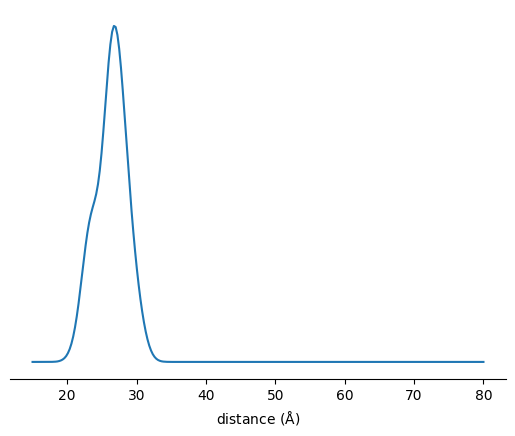

In [5]:
(SL1, vol1), (SL2, vol2)  = SLs[site1], SLs[site2]
r = np.linspace(15,80, 256)
P = xl.distance_distribution(SL1, SL2, r)

fig, ax = plt.subplots()
ax.plot(r, P)


ax.set_xlabel(r'distance ($\rm\AA$)')
ax.set_yticks([])
for spine in ax.spines:
    if spine == 'bottom' : continue
    ax.spines[spine].set_visible(False)

plt.show()
xl.save(SL1, SL2, t4l)